In [1]:
import uproot
import pandas as pd

# File paths (update with actual paths)
data_file_path = "/scratch/elena/WCTE-DataAnalysis-PIDcuts/MCDataComperison/root_files/WCTE_offline_R1574S0_VME1558.root"
mc_file_path = "/scratch/elena/WCTE-DataAnalysis-PIDcuts/MCDataComperison/root_files/pi+_260MeVc_1000evts_masked.root"

# Tree name
tree_name = "WCTEReadoutWindows"

# Number of events to read
N_EVENTS = 3000

# Open trees
data_tree = uproot.open(f"{data_file_path}:{tree_name}")
mc_tree = uproot.open(f"{mc_file_path}:{tree_name}")

# List of branches to read (all by default)
branches_to_read = data_tree.keys()

# Read limited entries into awkward arrays
df_data = data_tree.arrays(entry_stop=N_EVENTS, library="ak")
df_mc = mc_tree.arrays(entry_stop=N_EVENTS, library="ak")

# Quick check
print("Data events:", len(df_data))
print("MC events:", len(df_mc))

FileNotFoundError: file not found

    '/scratch/elena/WCTE-DataAnalysis-PIDcuts/MCDataComperison/root_files/WCTE_offline_R1574S0_VME1558.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [4]:
df_mc["event_number"]

<Array [0, 1, 2, 3, 4, ... 996, 997, 998, 999] type='1000 * int32'>

In [5]:
import sys
sys.path.append("/scratch/elena/WCTE_2025_commissioning/2025_data")
import DataQualityNotebooks.VMEAnalysis as VMEAnalysisModule
import importlib
importlib.reload(VMEAnalysisModule) 
from DataQualityNotebooks.VMEAnalysis import VMEAnalysis


config_file = "/scratch/elena/WCTE_2025_commissioning/config/lep_v51_config.json"
vme_analysis_cut = {
    "t4_qcut": 300,
    "hc0_cut": 150,
    "hc1_cut": 100,
    "act1_ev": 900,
    "act2_pi": 1800,
    "act2_mu_low": 2000,
    "act2_mu_high": 10000,
    "tdc_cut": 200
}

#extract the interesting variables
qdc_charges = df_data["beamline_pmt_qdc_charges"]
qdc_ids = df_data["beamline_pmt_qdc_ids"]
tdc_times = df_data["beamline_pmt_tdc_times"]
tdc_ids = df_data["beamline_pmt_tdc_ids"]

#initialize the VMEAnalysis object
vme = VMEAnalysis(config_file, vme_analysis_cut, runNumber=1574)

#load data into the analysis object
q, tdc = vme.load_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#apply cuts (mask)
vme.make_cuts_on_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#mask for pion-only
pion_mask = vme.getEventMask("pion-only")

#apply mask to the awkward array to filter events
df_data = df_data[pion_mask]

print(f"Selected {len(df_data)} pion-like events")     #out of {len(df_data)} total events")

Current Working Directory: /scratch/elena/WCTE-DataAnalysis-PIDcuts/MCDataComperison
[INFO] Total events: 1000
[INFO] Computing activity sums and TOF values...
[INFO] Applying additional cuts...
[INFO] Defining cut sequences...
[INFO] Converting to NumPy for stats...
[INFO] Gathering statistics per cut set...
Selected 16 pion-like events


In [6]:
# Access a single branch (e.g. event_number)
df_data["event_number"]  # or df_data.event_number

<Array [7, 39, 8, 70, 45, ... 42, 46, 26, 6] type='16 * int32'>

In [7]:
print("variables from data", df_data.fields)
print("variables from MC", df_mc.fields)

#weveform info only in Data

variables from data ['window_time', 'run_id', 'sub_run_id', 'spill_counter', 'event_number', 'readout_number', 'trigger_types', 'trigger_times', 'led_gains', 'led_dacsettings', 'led_ids', 'led_card_ids', 'led_slot_numbers', 'led_event_types', 'led_types', 'led_sequence_numbers', 'led_counters', 'hit_mpmt_card_ids', 'hit_pmt_channel_ids', 'hit_mpmt_slot_ids', 'hit_pmt_position_ids', 'hit_pmt_charges', 'hit_pmt_times', 'pmt_waveform_mpmt_card_ids', 'pmt_waveform_pmt_channel_ids', 'pmt_waveform_mpmt_slot_ids', 'pmt_waveform_pmt_position_ids', 'pmt_waveform_times', 'pmt_waveforms', 'beamline_pmt_qdc_charges', 'beamline_pmt_tdc_times', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids']
variables from MC ['event_number', 'window_time', 'run_id', 'sub_run_id', 'spill_counter', 'readout_number', 'hit_mpmt_card_ids', 'hit_pmt_channel_ids', 'hit_mpmt_slot_ids', 'hit_pmt_position_ids', 'hit_pmt_charges', 'hit_pmt_times', 'trigger_types', 'trigger_times', 'led_gains', 'led_dacsettings', 'led_ids', 'l

In [8]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Flatten to get all hit slot IDs across all events
data_slot_ids = ak.flatten(df_data["hit_mpmt_slot_ids"])
mc_slot_ids = ak.flatten(df_mc["hit_mpmt_slot_ids"])


n_data_events = len(df_data)
n_mc_events = len(df_mc)

mc_weights = np.ones_like(mc_slot_ids)*(n_data_events/n_mc_events)

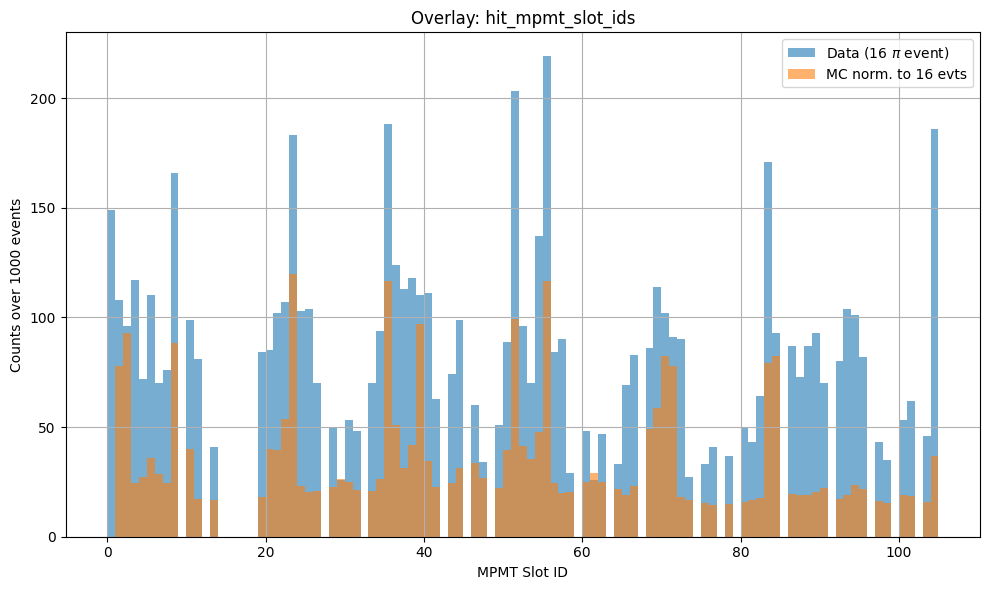

In [9]:
# Plot
plt.figure(figsize=(10, 6))
bins = range(0, max(ak.max(data_slot_ids), ak.max(mc_slot_ids)) + 1)

plt.hist(data_slot_ids, bins=bins, alpha=0.6, label=f"Data ({n_data_events} $\pi$ event)", histtype='stepfilled')
plt.hist(mc_slot_ids, bins=bins, alpha=0.6, label=f"MC norm. to {n_data_events} evts", weights=mc_weights, histtype='stepfilled')

plt.xlabel("MPMT Slot ID")
plt.ylabel(f"Counts over {N_EVENTS} events")
plt.title("Overlay: hit_mpmt_slot_ids")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Flatten jagged arrays to 1D
data_slot_ids = ak.flatten(df_data["hit_mpmt_slot_ids"])
mc_slot_ids = ak.flatten(df_mc["hit_mpmt_slot_ids"])

# Convert to sets (removes duplicates)
data_slots_set = set(data_slot_ids)
mc_slots_set = set(mc_slot_ids)

# Find exclusive entries
in_data_only = sorted(data_slots_set - mc_slots_set)
in_mc_only = sorted(mc_slots_set - data_slots_set)

print("Slot IDs in Data only (not in MC):", in_data_only)
print("Slot IDs in MC only (not in Data):", in_mc_only)


Slot IDs in Data only (not in MC): [-1, 0]
Slot IDs in MC only (not in Data): []


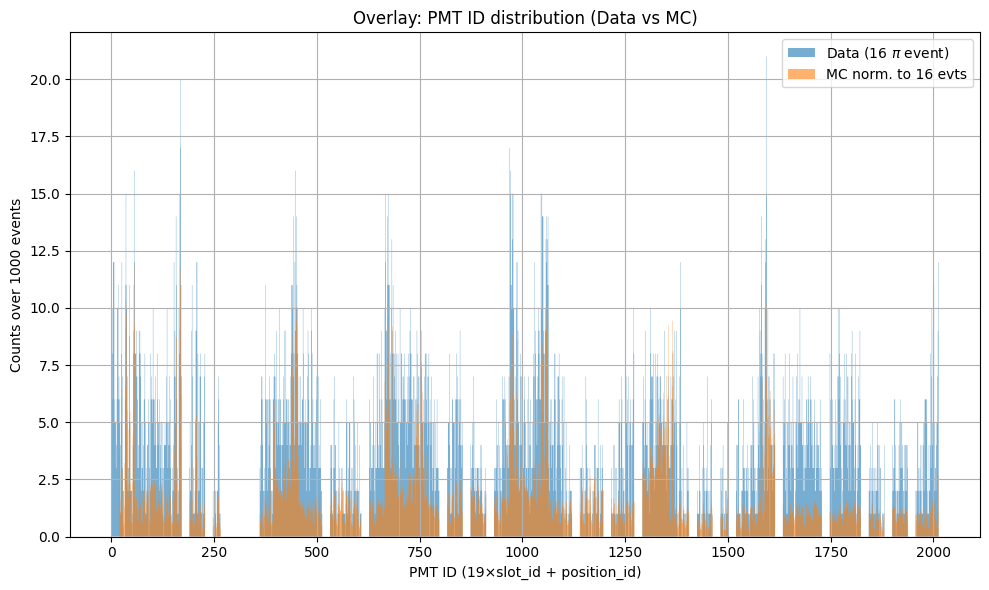

PMT IDs in Data only (not in MC): [-21, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
PMT IDs in MC only (not in Data): [30, 31, 32, 50, 91, 126, 146, 147, 220, 248, 249, 255, 256, 264, 371, 390, 539, 548, 549, 555, 557, 558, 559, 569, 582, 585, 595, 602, 604, 701, 774, 786, 835, 904, 906, 942, 943, 949, 1099, 1102, 1104, 1109, 1110, 1111, 1141, 1147, 1152, 1161, 1162, 1167, 1168, 1169, 1173, 1177, 1187, 1188, 1220, 1227, 1230, 1258, 1259, 1266, 1272, 1377, 1379, 1380, 1387, 1389, 1390, 1394, 1396, 1399, 1405, 1433, 1434, 1436, 1437, 1445, 1451, 1461, 1489, 1490, 1493, 1530, 1533, 1552, 1602, 1661, 1662, 1663, 1813, 1868, 1872, 1873, 1874, 1875, 1879, 1909, 1958]


In [11]:
import matplotlib.pyplot as plt
import awkward as ak

# Flatten slot_id and channel_id arrays
data_slots = ak.flatten(df_data["hit_mpmt_slot_ids"])
data_channels = ak.flatten(df_data["hit_pmt_channel_ids"])
data_positions = ak.flatten(df_data["hit_pmt_position_ids"])
mc_slots = ak.flatten(df_mc["hit_mpmt_slot_ids"])
mc_channels = ak.flatten(df_mc["hit_pmt_channel_ids"])
mc_positions = ak.flatten(df_mc["hit_pmt_position_ids"])


# Compute PMT IDs
data_pmt_ids = 19 * data_slots + data_positions
mc_pmt_ids = 19 * mc_slots + mc_positions

# Plot overlay histogram
plt.figure(figsize=(10, 6))
bins = range(0,
             max(ak.max(data_pmt_ids), ak.max(mc_pmt_ids)) + 1)

plt.hist(data_pmt_ids, bins=bins, alpha=0.6, label=f"Data ({n_data_events} $\pi$ event)", histtype='stepfilled')
plt.hist(mc_pmt_ids, bins=bins, alpha=0.6, label=f"MC norm. to {n_data_events} evts", weights=mc_weights, histtype='stepfilled')

plt.xlabel("PMT ID (19×slot_id + position_id)")
plt.ylabel(f"Counts over {N_EVENTS} events")
plt.title("Overlay: PMT ID distribution (Data vs MC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find exclusive PMT IDs
data_pmt_set = set(data_pmt_ids)
mc_pmt_set = set(mc_pmt_ids)

in_data_only = sorted(data_pmt_set - mc_pmt_set)
in_mc_only = sorted(mc_pmt_set - data_pmt_set)

print("PMT IDs in Data only (not in MC):", in_data_only)
print("PMT IDs in MC only (not in Data):", in_mc_only)


In [12]:
# Function to convert pmt_id back to (slot_id, channel_id)
def decode_pmt_ids(pmt_ids):
    return [(pid, pid // 19, pid % 19) for pid in sorted(pmt_ids)]

# Decode exclusive IDs
in_data_only_detailed = decode_pmt_ids(data_pmt_set - mc_pmt_set)
in_mc_only_detailed = decode_pmt_ids(mc_pmt_set - data_pmt_set)

# Print results
print("PMT IDs in Data only (not in MC):")
for pid, slot, ch in in_data_only_detailed:
    print(f"  pmt_id = {pid:4}, slot_id = {slot:2}, channel_id = {ch:2}")

print("\nPMT IDs in MC only (not in Data):")
for pid, slot, ch in in_mc_only_detailed:
    print(f"  pmt_id = {pid:4}, slot_id = {slot:2}, channel_id = {ch:2}")


PMT IDs in Data only (not in MC):
  pmt_id =  -21, slot_id = -2, channel_id = 17
  pmt_id =    0, slot_id =  0, channel_id =  0
  pmt_id =    1, slot_id =  0, channel_id =  1
  pmt_id =    2, slot_id =  0, channel_id =  2
  pmt_id =    3, slot_id =  0, channel_id =  3
  pmt_id =    4, slot_id =  0, channel_id =  4
  pmt_id =    5, slot_id =  0, channel_id =  5
  pmt_id =    6, slot_id =  0, channel_id =  6
  pmt_id =    7, slot_id =  0, channel_id =  7
  pmt_id =    8, slot_id =  0, channel_id =  8
  pmt_id =    9, slot_id =  0, channel_id =  9
  pmt_id =   10, slot_id =  0, channel_id = 10
  pmt_id =   11, slot_id =  0, channel_id = 11
  pmt_id =   12, slot_id =  0, channel_id = 12
  pmt_id =   13, slot_id =  0, channel_id = 13
  pmt_id =   14, slot_id =  0, channel_id = 14
  pmt_id =   15, slot_id =  0, channel_id = 15
  pmt_id =   16, slot_id =  0, channel_id = 16
  pmt_id =   17, slot_id =  0, channel_id = 17
  pmt_id =   18, slot_id =  0, channel_id = 18

PMT IDs in MC only (not i

In [13]:
# Unique sets (already computed earlier)
data_pmt_set = set(data_pmt_ids)
mc_pmt_set = set(mc_pmt_ids)

# Intersections
common_pmt_ids = data_pmt_set & mc_pmt_set

# Print counts
print(f"Unique PMT IDs in Data:     {len(data_pmt_set)}")
print(f"Unique PMT IDs in MC:       {len(mc_pmt_set)}")
print(f"Shared PMT IDs (Data & MC): {len(common_pmt_ids)}")
print(f"Only in Data:               {len(data_pmt_set - mc_pmt_set)}")
print(f"Only in MC:                 {len(mc_pmt_set - data_pmt_set)}")


Unique PMT IDs in Data:     1479
Unique PMT IDs in MC:       1558
Shared PMT IDs (Data & MC): 1459
Only in Data:               20
Only in MC:                 99


In [14]:
import numpy as np
import awkward as ak
from collections import defaultdict

# Constants
MAX_SLOT_ID = 110  # Explicit upper bound for slot IDs
BINS = 4000        # 1 ns resolution
TIME_RANGE = (0, 4000)

# Initialize output arrays
data_peak_times = np.full(MAX_SLOT_ID, np.nan)
mc_peak_times = np.full(MAX_SLOT_ID, np.nan)

# --- DATA ---

# Flatten and group per slot
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])

slot_time_map = defaultdict(list)
for slot, time in zip(slots_data, times_data):
    if 0 <= slot < MAX_SLOT_ID and time < TIME_RANGE[1]:
        slot_time_map[slot].append(time)

# Compute histogram-based peak
for slot, times in slot_time_map.items():
    if len(times) < 10:
        continue
    hist, bin_edges = np.histogram(times, bins=BINS, range=TIME_RANGE)
    peak_bin = np.argmax(hist)
    peak_time = bin_edges[peak_bin]  # left edge of the bin
    data_peak_times[slot] = peak_time

# --- MC ---

slots_mc = ak.flatten(df_mc["hit_mpmt_slot_ids"])
times_mc = ak.flatten(df_mc["hit_pmt_times"])

if len(slots_mc) > 0:
    example_slot = slots_mc[0]
    times_for_slot = [
        time for slot, time in zip(slots_mc, times_mc)
        if slot == example_slot and time < TIME_RANGE[1]
    ]

    if len(times_for_slot) >= 10:
        hist, bin_edges = np.histogram(times_for_slot, bins=BINS, range=TIME_RANGE)
        peak_bin = np.argmax(hist)
        peak_time = bin_edges[peak_bin]

        # Apply to all valid slots in MC
        for slot in set(slots_mc):
            if 0 <= slot < MAX_SLOT_ID:
                mc_peak_times[slot] = peak_time


In [15]:
print(data_peak_times[105])

1615.0


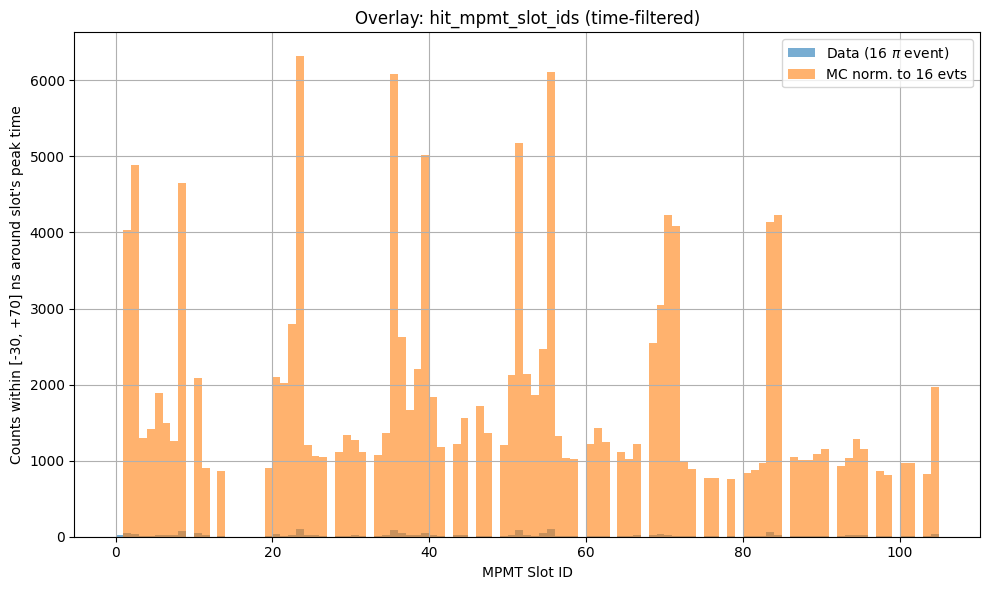

In [16]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Define time window around the peak [−30, +70] ns
time_window_low = -30
time_window_high = +70

# --- DATA Filtering ---
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])

filtered_slots_data = [
    slot for slot, time in zip(slots_data, times_data)
    if not np.isnan(data_peak_times[slot]) and
       (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high)
]

# --- MC Filtering ---
slots_mc = ak.flatten(df_mc["hit_mpmt_slot_ids"])
times_mc = ak.flatten(df_mc["hit_pmt_times"])

filtered_slots_mc = [
    slot for slot, time in zip(slots_mc, times_mc)
    if not np.isnan(mc_peak_times[slot]) and
       (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high)
]

# --- Plot ---
plt.figure(figsize=(10, 6))
bins = range(0, max(max(filtered_slots_data, default=0), max(filtered_slots_mc, default=0)) + 1)

plt.hist(filtered_slots_data, bins=bins, alpha=0.6, label=f"Data ({n_data_events} $\pi$ event)", histtype='stepfilled')
plt.hist(filtered_slots_mc, bins=bins, alpha=0.6, label=f"MC norm. to {n_data_events} evts", histtype='stepfilled')

plt.xlabel("MPMT Slot ID")
plt.ylabel("Counts within [-30, +70] ns around slot's peak time")
plt.title("Overlay: hit_mpmt_slot_ids (time-filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Same plot but MC peak times found per slot, just like for data

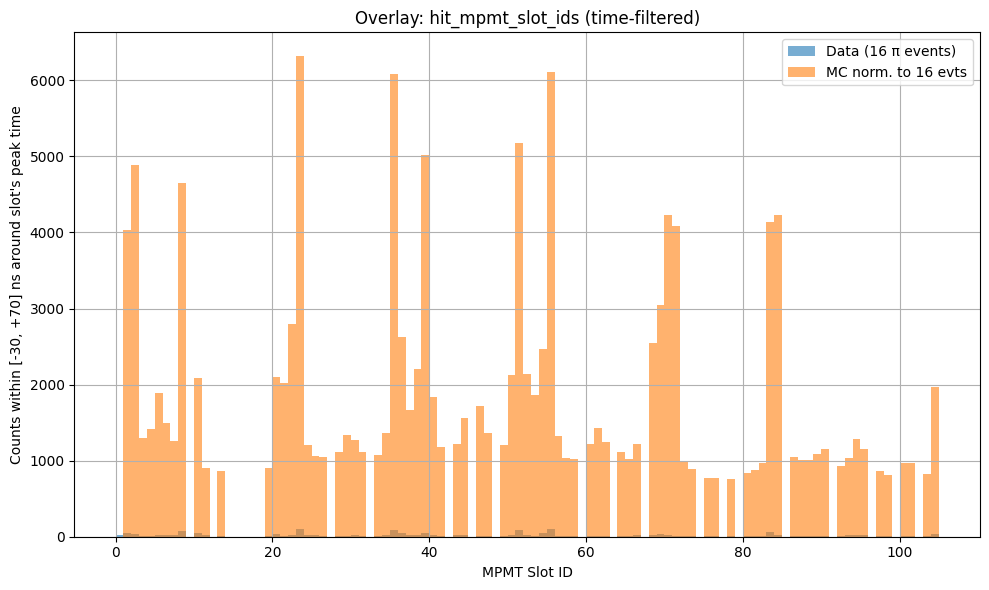

In [17]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
from collections import defaultdict

# Constants (should be consistent with earlier cell)
MAX_SLOT_ID = 110
BINS = 4000
TIME_RANGE = (0, 4000)

# Define time window around the peak [−30, +70] ns
time_window_low = -30
time_window_high = +70

# --- DATA Peak-finding (assuming data_peak_times already computed) ---
# (If you want to recompute here, you could, but I assume it's done)

# --- MC Peak-finding per slot (improved) ---
slots_mc = ak.flatten(df_mc["hit_mpmt_slot_ids"])
times_mc = ak.flatten(df_mc["hit_pmt_times"])

mc_peak_times = np.full(MAX_SLOT_ID, np.nan)
slot_time_map_mc = defaultdict(list)
for slot, time in zip(slots_mc, times_mc):
    if 0 <= slot < MAX_SLOT_ID and time < TIME_RANGE[1]:
        slot_time_map_mc[slot].append(time)

for slot, times in slot_time_map_mc.items():
    if len(times) < 10:
        continue
    hist, bin_edges = np.histogram(times, bins=BINS, range=TIME_RANGE)
    peak_bin = np.argmax(hist)
    peak_time = bin_edges[peak_bin]
    mc_peak_times[slot] = peak_time

# --- DATA Filtering ---
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])

filtered_slots_data = [
    slot for slot, time in zip(slots_data, times_data)
    if 0 <= slot < MAX_SLOT_ID and
       not np.isnan(data_peak_times[slot]) and
       (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high)
]

# --- MC Filtering ---
filtered_slots_mc = [
    slot for slot, time in zip(slots_mc, times_mc)
    if 0 <= slot < MAX_SLOT_ID and
       not np.isnan(mc_peak_times[slot]) and
       (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high)
]

# --- Plot ---
plt.figure(figsize=(10, 6))
bins = range(0, max(max(filtered_slots_data, default=0), max(filtered_slots_mc, default=0)) + 1)

plt.hist(filtered_slots_data, bins=bins, alpha=0.6, label=f"Data ({n_data_events} π events)", histtype='stepfilled')
plt.hist(filtered_slots_mc, bins=bins, alpha=0.6, label=f"MC norm. to {n_data_events} evts", histtype='stepfilled')

plt.xlabel("MPMT Slot ID")
plt.ylabel("Counts within [-30, +70] ns around slot's peak time")
plt.title("Overlay: hit_mpmt_slot_ids (time-filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


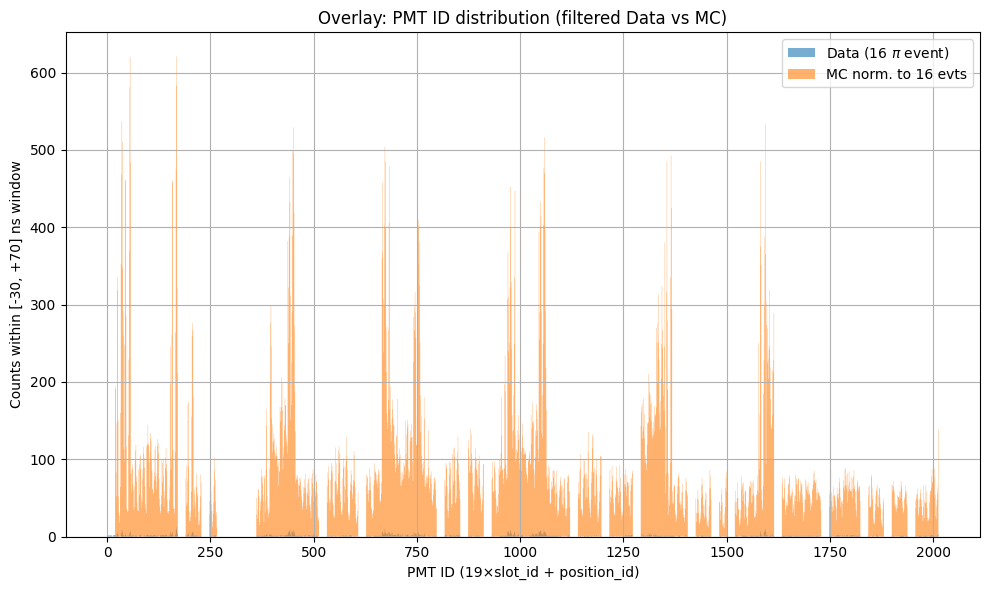

PMT IDs in Data only (not in MC): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]
PMT IDs in MC only (not in Data): [21, 28, 29, 30, 31, 32, 42, 47, 49, 50, 64, 65, 66, 72, 73, 75, 76, 77, 83, 84, 85, 86, 88, 90, 91, 94, 116, 121, 124, 125, 126, 127, 146, 147, 161, 162, 163, 192, 193, 198, 199, 201, 219, 220, 223, 247, 248, 249, 251, 253, 255, 256, 257, 263, 264, 265, 362, 369, 371, 388, 390, 391, 404, 414, 416, 418, 423, 425, 427, 474, 475, 476, 481, 482, 483, 484, 492, 493, 502, 503, 510, 511, 512, 533, 536, 537, 538, 539, 543, 546, 547, 548, 549, 550, 552, 555, 556, 557, 558, 559, 560, 563, 565, 567, 568, 569, 574, 581, 582, 585, 586, 591, 593, 594, 595, 596, 597, 600, 601, 602, 603, 604, 605, 606, 631, 632, 636, 639, 640, 641, 642, 643, 644, 655, 662, 701, 716, 717, 719, 720, 722, 732, 733, 739, 742, 759, 762, 770, 772, 773, 774, 775, 776, 777, 780, 782, 783, 785, 786, 787, 791, 793, 797, 818, 823, 824, 825, 826, 827, 835, 840, 845, 877, 880, 883, 884, 885, 886, 887,

In [18]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Time window bounds
time_window_low = -30
time_window_high = +70

# --- Data filtering ---
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
positions_data = ak.flatten(df_data["hit_pmt_position_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])

filtered_pmt_ids_data = [
    19 * slot + pos
    for slot, pos, time in zip(slots_data, positions_data, times_data)
    if not np.isnan(data_peak_times[slot]) and
       (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high)
]

# --- MC filtering ---
slots_mc = ak.flatten(df_mc["hit_mpmt_slot_ids"])
positions_mc = ak.flatten(df_mc["hit_pmt_position_ids"])
times_mc = ak.flatten(df_mc["hit_pmt_times"])

filtered_pmt_ids_mc = [
    19 * slot + pos
    for slot, pos, time in zip(slots_mc, positions_mc, times_mc)
    if not np.isnan(mc_peak_times[slot]) and
       (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high)
]

# --- Plot overlay ---
plt.figure(figsize=(10, 6))
bins = range(0,
             max(max(filtered_pmt_ids_data, default=0), max(filtered_pmt_ids_mc, default=0)) + 1)

plt.hist(filtered_pmt_ids_data, bins=bins, alpha=0.6,  label=f"Data ({n_data_events} $\pi$ event)", histtype='stepfilled')
plt.hist(filtered_pmt_ids_mc, bins=bins, alpha=0.6, label=f"MC norm. to {n_data_events} evts", histtype='stepfilled')

plt.xlabel("PMT ID (19×slot_id + position_id)")
plt.ylabel("Counts within [-30, +70] ns window")
plt.title("Overlay: PMT ID distribution (filtered Data vs MC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Exclusive PMT IDs ---
data_pmt_set = set(filtered_pmt_ids_data)
mc_pmt_set = set(filtered_pmt_ids_mc)

in_data_only = sorted(data_pmt_set - mc_pmt_set)
in_mc_only = sorted(mc_pmt_set - data_pmt_set)

print("PMT IDs in Data only (not in MC):", in_data_only)
print("PMT IDs in MC only (not in Data):", in_mc_only)



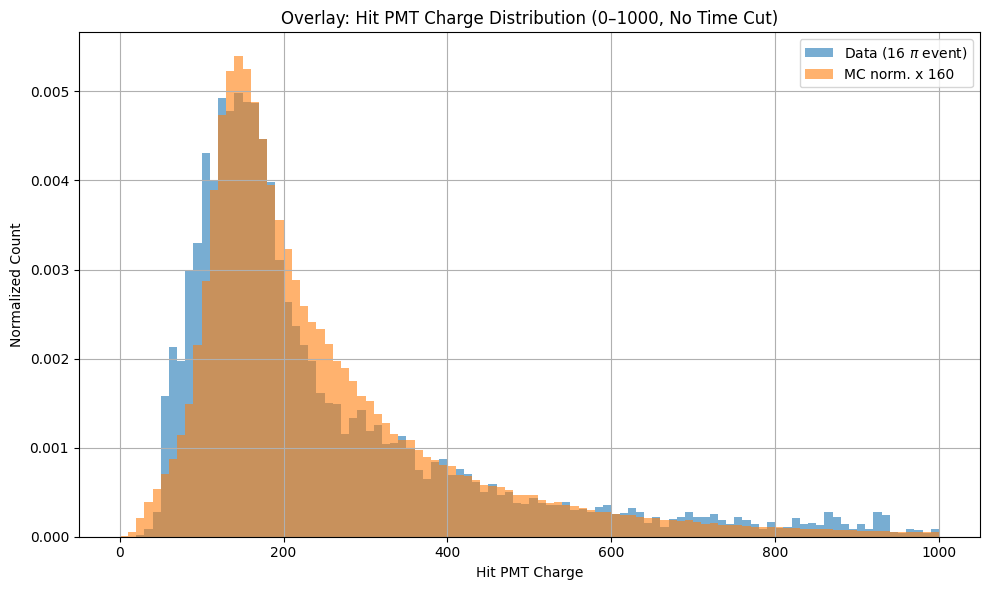

In [19]:
import matplotlib.pyplot as plt
import awkward as ak

# Flatten and scale
charges_data = ak.flatten(df_data["hit_pmt_charges"]) 
charges_mc = ak.flatten(df_mc["hit_pmt_charges"]) *160

# Optional: filter to [0, 1000] range before plotting
charges_data = charges_data[(charges_data >= 0) & (charges_data <= 1000)]
charges_mc = charges_mc[(charges_mc >= 0) & (charges_mc <= 1000)]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(charges_data, bins=100, range=(0, 1000), alpha=0.6,  label=f"Data ({n_data_events} $\pi$ event)", histtype='stepfilled', density=True)
plt.hist(charges_mc, bins=100, range=(0, 1000), alpha=0.6, label=f"MC norm. x 160", histtype='stepfilled', density=True)

plt.xlabel("Hit PMT Charge")
plt.ylabel("Normalized Count")
plt.title("Overlay: Hit PMT Charge Distribution (0–1000, No Time Cut)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


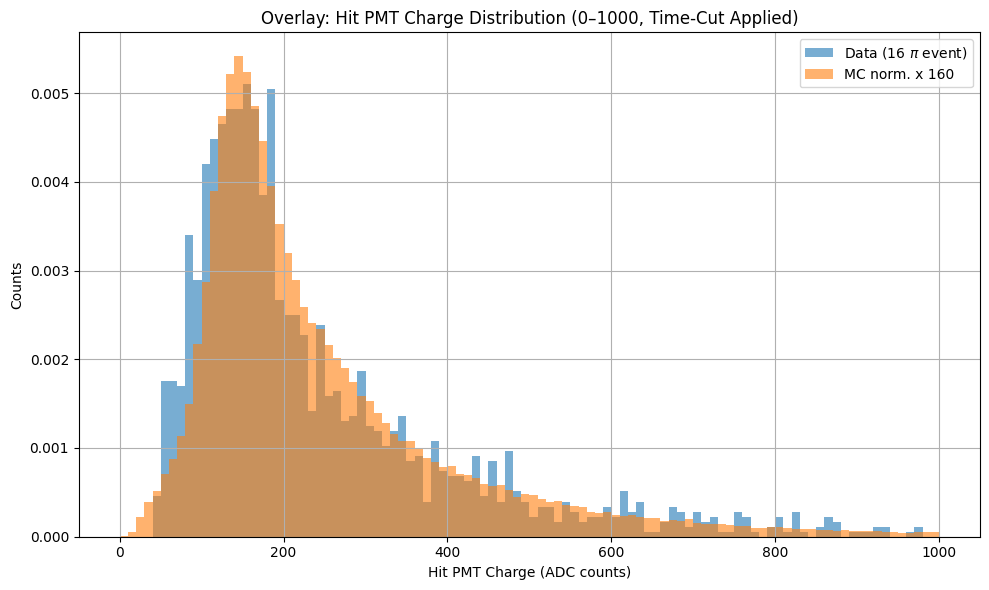

In [20]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Define time window
time_window_low = -30
time_window_high = 70

# --- DATA ---
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])
charges_data = ak.flatten(df_data["hit_pmt_charges"])

# Apply time window cut per slot
filtered_charges_data = [
    charge for slot, time, charge in zip(slots_data, times_data, charges_data)
    if not np.isnan(data_peak_times[slot]) and
       (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high)
]

# --- MC ---
slots_mc = ak.flatten(df_mc["hit_mpmt_slot_ids"])
times_mc = ak.flatten(df_mc["hit_pmt_times"])
charges_mc = ak.flatten(df_mc["hit_pmt_charges"]) 

filtered_charges_mc = [
    charge * 160 for slot, time, charge in zip(slots_mc, times_mc, charges_mc)
    if not np.isnan(mc_peak_times[slot]) and
       (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high)
]

# MC*160 for visual matching, no calibration performed yet 



# Filter to [0, 1000] charge range
filtered_charges_data = [c for c in filtered_charges_data if 0 <= c <= 1000]
filtered_charges_mc = [c for c in filtered_charges_mc if 0 <= c <= 1000]

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.hist(filtered_charges_data, bins=100, range=(0, 1000), alpha=0.6,  label=f"Data ({n_data_events} $\pi$ event)", histtype='stepfilled', density=True)
plt.hist(filtered_charges_mc, bins=100, range=(0, 1000), alpha=0.6,  label=f"MC norm. x 160", histtype='stepfilled', density=True)

plt.xlabel("Hit PMT Charge (ADC counts)")
plt.ylabel("Counts")
plt.title("Overlay: Hit PMT Charge Distribution (0–1000, Time-Cut Applied)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


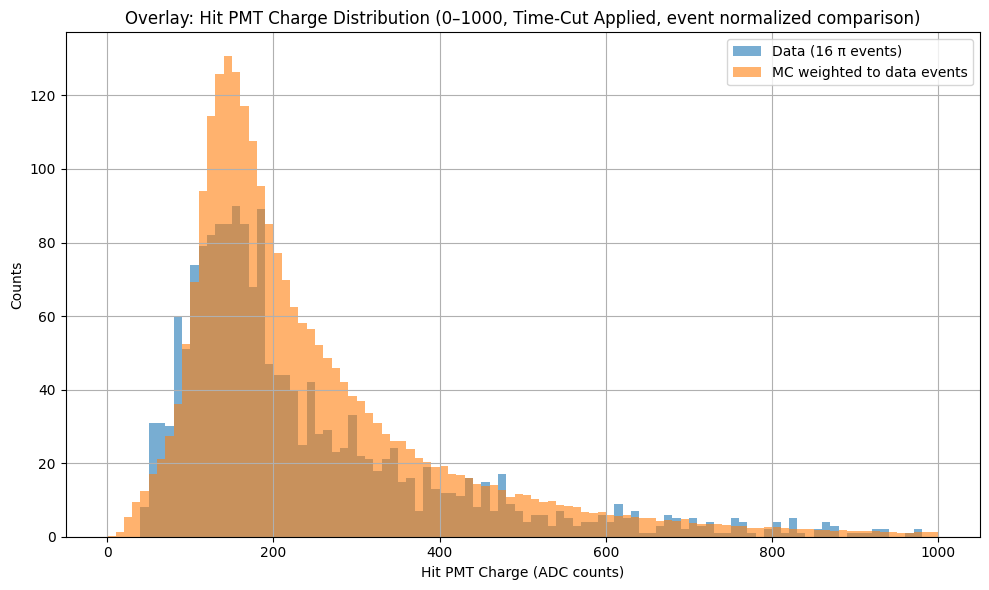

In [21]:
mc_weights = np.ones_like(filtered_charges_mc)*(n_data_events / n_mc_events)

plt.figure(figsize=(10, 6))
plt.hist(filtered_charges_data, bins=100, range=(0, 1000), alpha=0.6,
         label=f"Data ({n_data_events} π events)", histtype='stepfilled')
plt.hist(filtered_charges_mc, bins=100, range=(0, 1000), alpha=0.6,
         label=f"MC weighted to data events", weights=mc_weights, histtype='stepfilled')
plt.xlabel("Hit PMT Charge (ADC counts)")
plt.ylabel("Counts")
plt.title("Overlay: Hit PMT Charge Distribution (0–1000, Time-Cut Applied, event normalized comparison)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

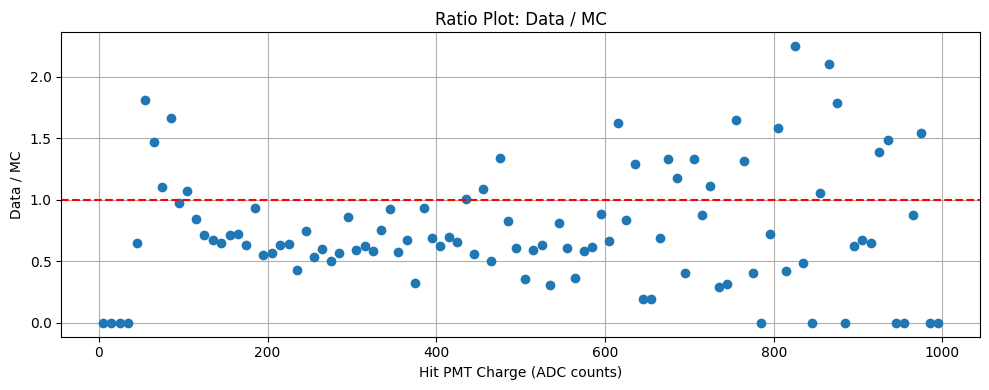

In [22]:
# Same binning
bins = np.linspace(0, 1000, 101)
data_hist, _ = np.histogram(filtered_charges_data, bins=bins)
mc_hist, _ = np.histogram(filtered_charges_mc, bins=bins, weights=mc_weights)

# Avoid divide-by-zero
mc_hist = np.where(mc_hist == 0, np.nan, mc_hist)
ratio = data_hist/mc_hist
bin_centers = (bins[:-1] + bins[1:])/2

# Plot ratio
plt.figure(figsize=(10, 4))
plt.plot(bin_centers, ratio, marker='o', linestyle='none')
plt.axhline(1.0, color='red', linestyle='--')
plt.xlabel("Hit PMT Charge (ADC counts)")
plt.ylabel("Data / MC")
plt.title("Ratio Plot: Data / MC")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import numpy as np

bins = np.linspace(0, 1000, 101)  # 100 bins between 0 and 1000

data_counts, _ = np.histogram(filtered_charges_data, bins=bins)
mc_counts, _ = np.histogram(filtered_charges_mc, bins=bins, weights=mc_weights)


#chi2
valid = mc_counts > 0
problematic_bins = (mc_counts == 0) & (data_counts > 0)
n_problematic = np.sum(problematic_bins)
print(f"# MC bins equal to 0 and Data > 0: {n_problematic}")


chi2 = np.sum(((data_counts[valid]-mc_counts[valid])**2)/mc_counts[valid])
dof = np.sum(valid) - 1  # degrees of freedom (number of bins used - 1)

print(f"Chi-square: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"Chi-square/dof = {chi2/dof:.2f}")


chi2_per_bin = ((data_counts - mc_counts)**2) / np.where(mc_counts == 0, 1e-6, mc_counts)
sorted_bins = np.argsort(chi2_per_bin)[::-1]  # bins con más contribución al chi2


top_bins = sorted_bins[:5]

table_data = {
    "Bin": top_bins,
    "Bin Center (ADC)": bin_centers[top_bins],
    "Data": data_counts[top_bins],
    "MC": mc_counts[top_bins],
    "Chi2 contribution": chi2_per_bin[top_bins]
}

df = pd.DataFrame(table_data)
print(df)

# MC bins equal to 0 and Data > 0: 0
Chi-square: 349.44
Degrees of freedom: 99
Chi-square/dof = 3.53
   Bin  Bin Center (ADC)  Data       MC  Chi2 contribution
0   23             235.0    25   58.224          18.958405
1   19             195.0    47   85.120          17.071598
2   14             145.0    85  130.624          15.935428
3    8              85.0    60   36.096          15.830043
4   17             175.0    68  107.648          14.602816


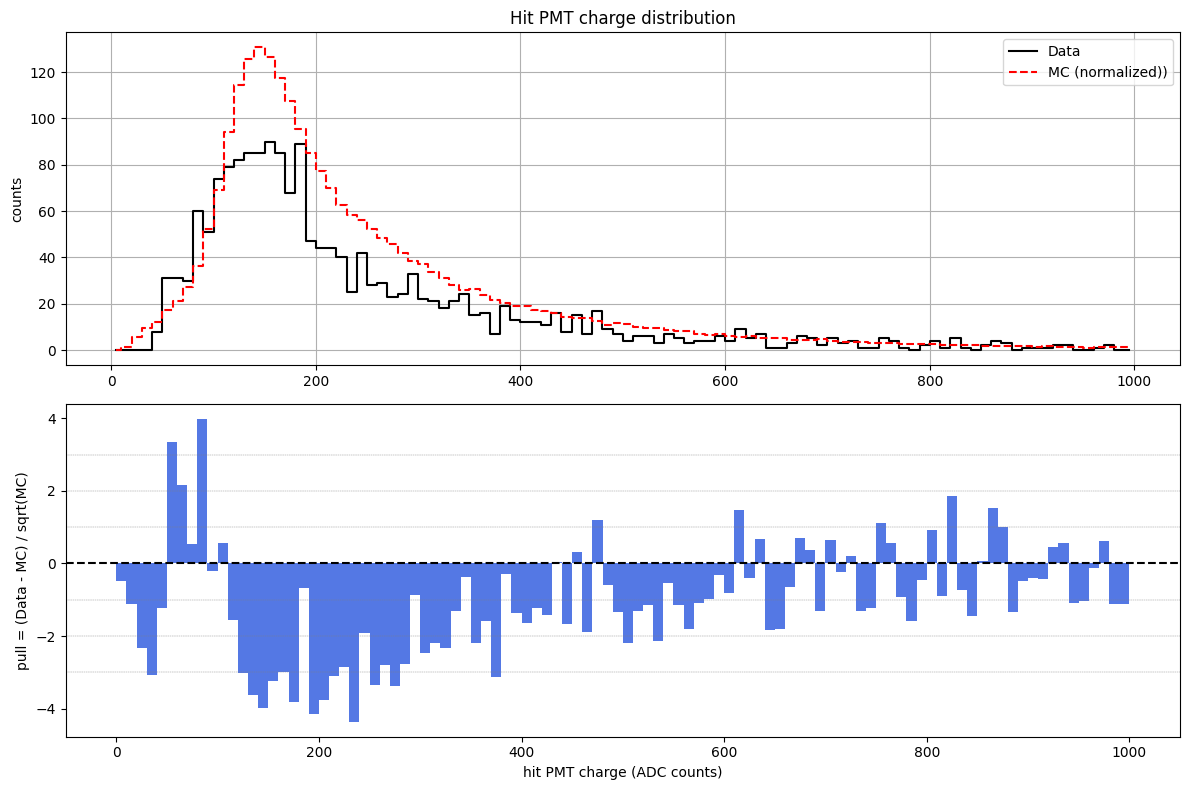

In [24]:
import matplotlib.pyplot as plt

bin_centers = 0.5 * (bins[:-1] + bins[1:])

plt.figure(figsize=(12, 8))

#data vs MC
plt.subplot(2,1,1)
plt.step(bin_centers, data_counts, where='mid', label='Data', color='black')
plt.step(bin_centers, mc_counts, where='mid', label='MC (normalized))', color='red', linestyle='--')
plt.ylabel('counts')
plt.title('Hit PMT charge distribution')
plt.legend()
plt.grid(True)

# pull 
plt.subplot(2,1,2)
pull = np.zeros_like(data_counts, dtype=float)
pull[valid] = (data_counts[valid]-mc_counts[valid])/np.sqrt(mc_counts[valid])
for n in [1, 2, 3]:
    plt.axhline(n, color='gray', linestyle='--', linewidth=0.3)
    plt.axhline(-n, color='gray', linestyle='--', linewidth=0.3)
plt.bar(bin_centers, pull, width=(bins[1]-bins[0]), color='royalblue', alpha=0.9)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('hit PMT charge (ADC counts)')
plt.ylabel('pull = (Data - MC) / sqrt(MC)')
#plt.grid(True)

plt.tight_layout()
plt.show()


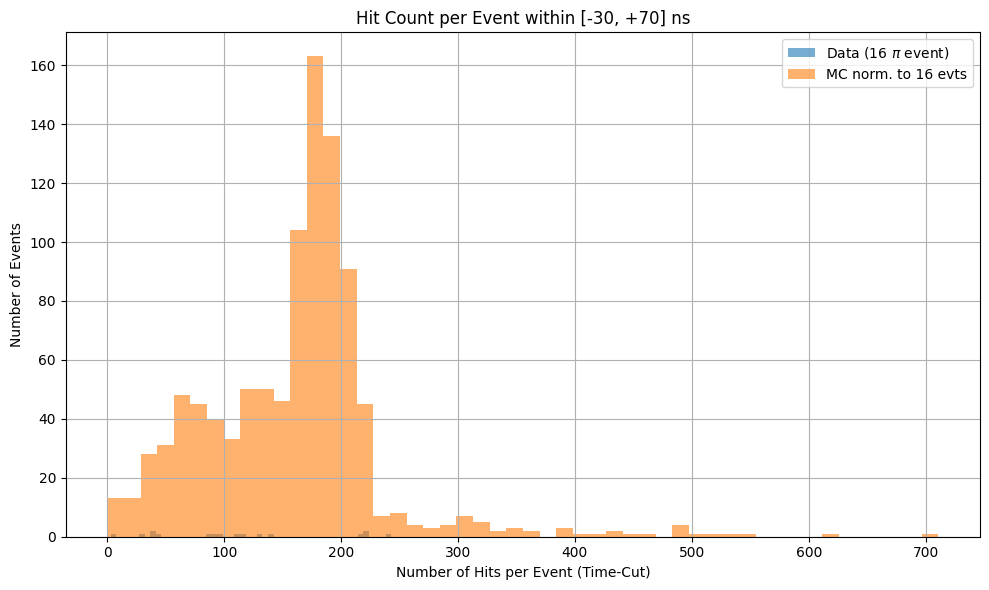

In [25]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Time window
time_window_low = -30
time_window_high = 70

# Prepare per-event arrays
slots_data = df_data["hit_mpmt_slot_ids"]
times_data = df_data["hit_pmt_times"]

slots_mc = df_mc["hit_mpmt_slot_ids"]
times_mc = df_mc["hit_pmt_times"]

# Count hits per event
hits_per_event_data = [
    sum(
        (not np.isnan(data_peak_times[slot]) and
         (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high))
        for slot, time in zip(event_slots, event_times)
    )
    for event_slots, event_times in zip(slots_data, times_data)
]

hits_per_event_mc = [
    sum(
        (not np.isnan(mc_peak_times[slot]) and
         (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high))
        for slot, time in zip(event_slots, event_times)
    )
    for event_slots, event_times in zip(slots_mc, times_mc)
]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(hits_per_event_data, bins=50, alpha=0.6,  label=f"Data ({n_data_events} $\pi$ event)", histtype='stepfilled')
plt.hist(hits_per_event_mc, bins=50, alpha=0.6,  label=f"MC norm. to {n_data_events} evts", histtype='stepfilled')
plt.xlabel("Number of Hits per Event (Time-Cut)")
plt.ylabel("Number of Events")
plt.title("Hit Count per Event within [-30, +70] ns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



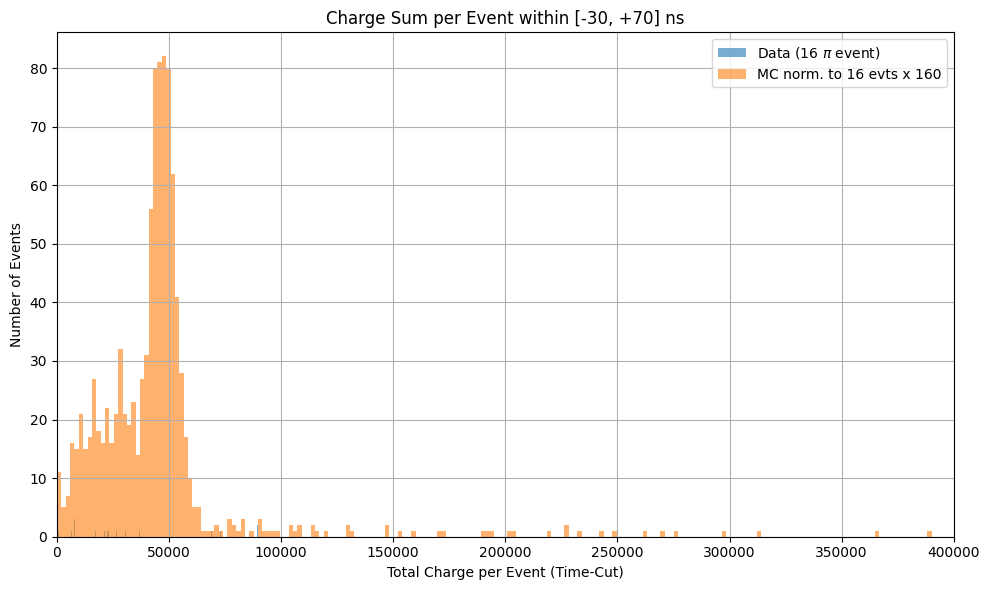

In [26]:
charges_data = df_data["hit_pmt_charges"]
charges_mc = df_mc["hit_pmt_charges"]

# Total charge per event
charge_per_event_data = [
    sum(
        charge
        for slot, time, charge in zip(event_slots, event_times, event_charges)
        if not np.isnan(data_peak_times[slot]) and
           (data_peak_times[slot] + time_window_low) <= time <= (data_peak_times[slot] + time_window_high)
    )
    for event_slots, event_times, event_charges in zip(slots_data, times_data, charges_data)
]

charge_per_event_mc = [
    sum(
        charge * 160
        for slot, time, charge in zip(event_slots, event_times, event_charges)
        if not np.isnan(mc_peak_times[slot]) and
           (mc_peak_times[slot] + time_window_low) <= time <= (mc_peak_times[slot] + time_window_high)
    )
    for event_slots, event_times, event_charges in zip(slots_mc, times_mc, charges_mc)
]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(charge_per_event_data, bins=200, alpha=0.6,  label=f"Data ({n_data_events} $\pi$ event)", histtype='stepfilled')
plt.hist(charge_per_event_mc, bins=200, alpha=0.6,  label=f"MC norm. to {n_data_events} evts x 160", histtype='stepfilled')
plt.xlabel("Total Charge per Event (Time-Cut)")
plt.ylabel("Number of Events")
plt.title("Charge Sum per Event within [-30, +70] ns")
plt.xlim(0, 400000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


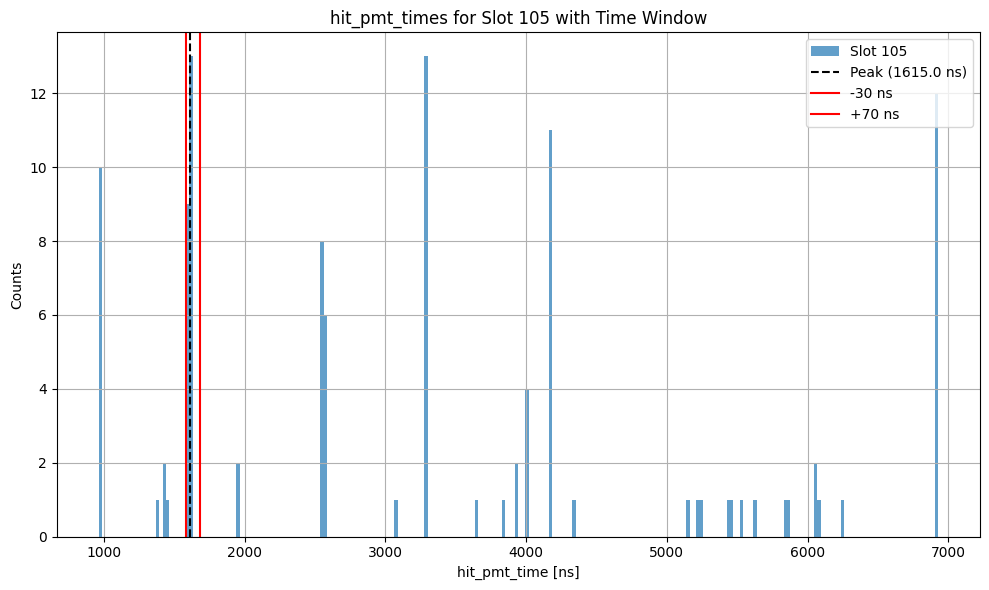

In [40]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Flatten relevant arrays
slots = ak.flatten(df_data["hit_mpmt_slot_ids"])
times = ak.flatten(df_data["hit_pmt_times"])

# Slot to filter
target_slot = 105
peak_time = data_peak_times[target_slot]

# Filter hit times for slot 105
slot105_times = [t for s, t in zip(slots, times) if s == target_slot]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(slot105_times, bins=250, alpha=0.7, label="Slot 105", histtype='stepfilled')

# Add vertical lines
plt.axvline(peak_time, linestyle="--", color="black", label=f"Peak ({peak_time:.1f} ns)")
plt.axvline(peak_time - 30, linestyle="-", color="red", label="-30 ns")
plt.axvline(peak_time + 70, linestyle="-", color="red", label="+70 ns")

plt.xlabel("hit_pmt_time [ns]")
plt.ylabel("Counts")
plt.title("hit_pmt_times for Slot 105 with Time Window")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


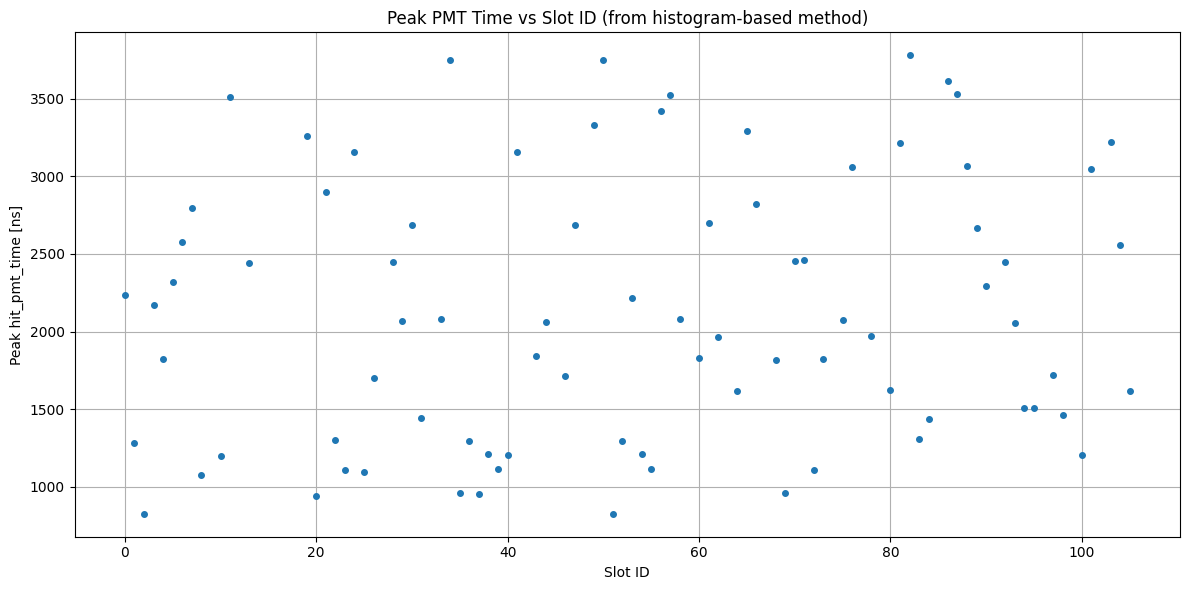

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure NaNs are filtered
slot_ids = np.arange(len(data_peak_times))
valid_mask = ~np.isnan(data_peak_times)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(slot_ids[valid_mask], data_peak_times[valid_mask], "o", markersize=4)

plt.xlabel("Slot ID")
plt.ylabel("Peak hit_pmt_time [ns]")
plt.title("Peak PMT Time vs Slot ID (from histogram-based method)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
print("Slot 105 times (count):", len(slot_time_map[105]))
print("Histogram-based peak time:", data_peak_times[105])


Slot 105 times (count): 70
Histogram-based peak time: 1615.0


In [30]:
print("MAX_SLOT_ID:", MAX_SLOT_ID)
print("Length of data_peak_times:", len(data_peak_times))
print("Slot 105 in array:", 105 < len(data_peak_times))


MAX_SLOT_ID: 110
Length of data_peak_times: 110
Slot 105 in array: True


Slot 105: 41 entries
Peak bin index: 2559
Peak time (left edge of bin): 2559.0 ns
Bin count at peak: 4
Histogram array (excerpt): [0 0 0 3 2 4 2 0 0 0 1]


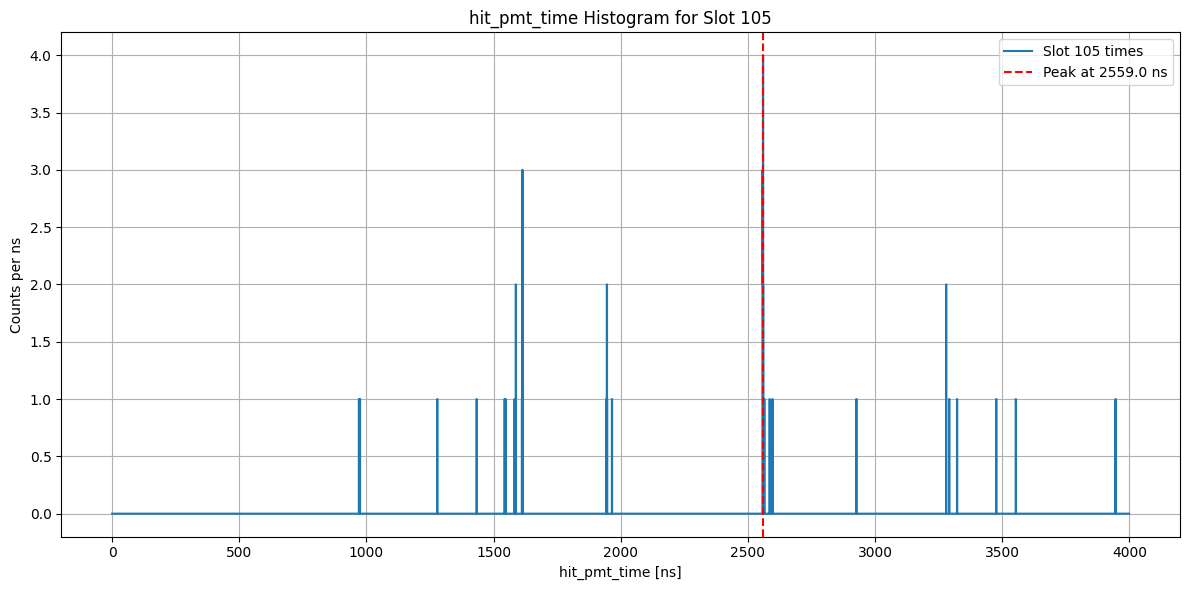

In [42]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

# Flatten full arrays
slots_data = ak.flatten(df_data["hit_mpmt_slot_ids"])
times_data = ak.flatten(df_data["hit_pmt_times"])

# Select times for slot 105 and apply <4000 ns cut
slot = 104
slot105_times = [t for s, t in zip(slots_data, times_data) if s == slot and t < 4000]

# Build histogram (1 ns bins from 0 to 4000)
hist, bin_edges = np.histogram(slot105_times, bins=4000, range=(0, 4000))

# Find peak bin
peak_bin = np.argmax(hist)
peak_time = bin_edges[peak_bin]

# Print debug info
print(f"Slot 105: {len(slot105_times)} entries")
print(f"Peak bin index: {peak_bin}")
print(f"Peak time (left edge of bin): {peak_time:.1f} ns")
print(f"Bin count at peak: {hist[peak_bin]}")
print("Histogram array (excerpt):", hist[peak_bin-5:peak_bin+6])  # show a slice near the peak

# Plot histogram
plt.figure(figsize=(12, 6))
plt.plot(bin_edges[:-1], hist, drawstyle='steps-post', label="Slot 105 times")
plt.axvline(peak_time, color='red', linestyle='--', label=f"Peak at {peak_time:.1f} ns")
plt.xlabel("hit_pmt_time [ns]")
plt.ylabel("Counts per ns")
plt.title("hit_pmt_time Histogram for Slot 105")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
print(data_peak_times[105])

1615.0


Adding plots

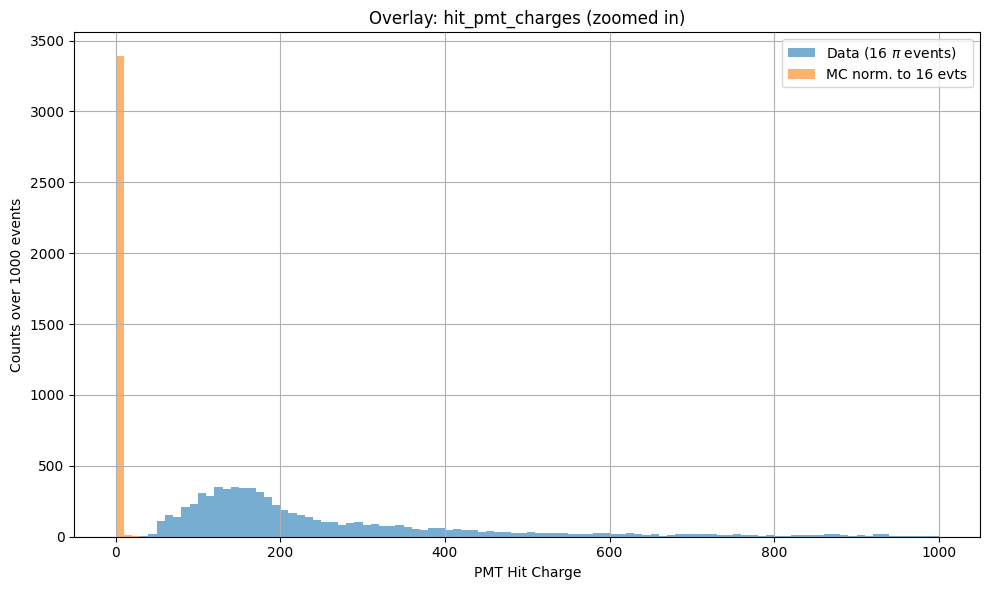

In [33]:
# Flatten charges
data_charges = ak.flatten(df_data["hit_pmt_charges"])
mc_charges = ak.flatten(df_mc["hit_pmt_charges"])

# Optional: set binning parameters
charge_bins = np.linspace(0, max(ak.max(data_charges), ak.max(mc_charges)), 100)


mc_weights = np.ones_like(mc_charges) * (n_data_events/n_mc_events)

plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=100, alpha=0.6, label=f"Data ({n_data_events} $\pi$ events)", histtype='stepfilled', range=(0, 1000))
plt.hist(mc_charges, bins=100, alpha=0.6, weights=mc_weights, label=f"MC norm. to {n_data_events} evts", histtype='stepfilled', range=(0, 1000))

plt.xlabel("PMT Hit Charge")
plt.ylabel(f"Counts over {N_EVENTS} events")
plt.title("Overlay: hit_pmt_charges (zoomed in)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



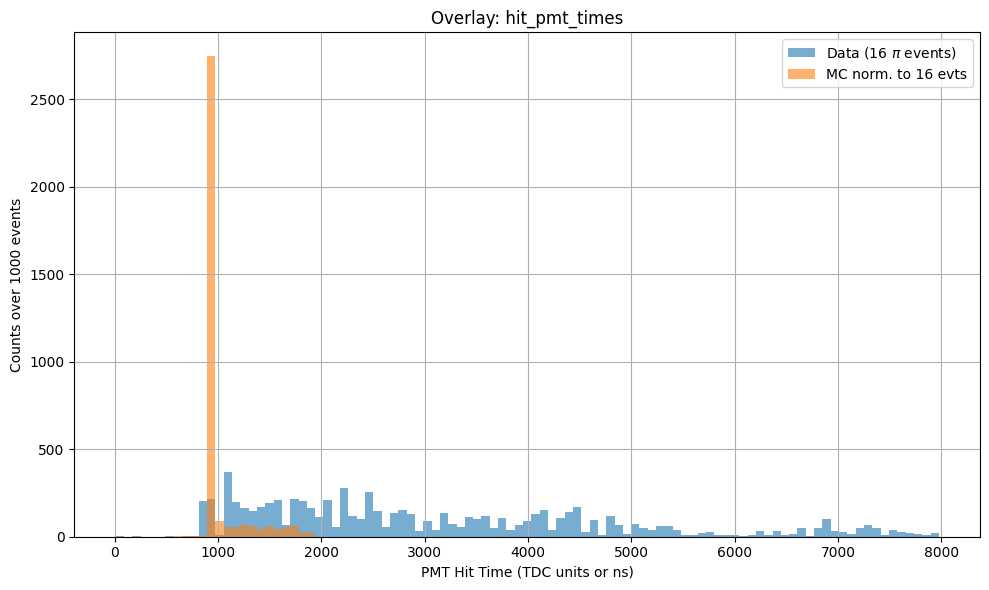

In [34]:
# Flatten times
data_times = ak.flatten(df_data["hit_pmt_times"])
mc_times = ak.flatten(df_mc["hit_pmt_times"])

# Optional: set binning parameters
time_bins = np.linspace(min(ak.min(data_times), ak.min(mc_times)),
                        max(ak.max(data_times), ak.max(mc_times)), 100)

# MC weights
mc_weights = np.ones_like(mc_times) * (n_data_events / n_mc_events)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(data_times, bins=time_bins, alpha=0.6, label=f"Data ({n_data_events} $\pi$ events)", histtype='stepfilled')
plt.hist(mc_times, bins=time_bins, alpha=0.6, weights=mc_weights, label=f"MC norm. to {n_data_events} evts", histtype='stepfilled')

plt.xlabel("PMT Hit Time (TDC units or ns)")
plt.ylabel(f"Counts over {N_EVENTS} events")
plt.title("Overlay: hit_pmt_times")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
